# An example of implementing the Re-QGAN

In [1]:
from qGAN import * 
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from sklearn.decomposition import PCA
#
%load_ext autoreload
%autoreload 2

2023-10-18 11:02:29.294229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training Re-QGAN

In [15]:
"""
n_q : number of qubits to use for the generator. 
n_comp_max : number of mnist images to train the re-qgan on.
idx: the specific digit to train re-qgan on.
epochs: The number of epochs the re-qgan runs for.
"""

n_q = 2 
shape = 'digits'
data, data_decomp, pca_ = reduced_data(n_q=n_q, shape=shape, n_comp_max=10, idx = 0) 
algo = qgan(qubits = [i for i in range(n_q)], data = data, backend = 'simulator', qc_real_build=False, mock_backend=False, opt_maxevals=200)
output  = algo.game(epochs=5)

####################
epoch : 0
disc training
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 9 (seed=758141, Wed Oct 18 13:27:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.397025055810566e-01 1.0e+00 9.68e-02  9e-02  1e-01 0:01.1
    2     16 3.155296461617323e-01 1.2e+00 9.25e-02  9e-02  1e-01 0:01.9
    3     24 2.710998089670794e-01 1.2e+00 9.64e-02  9e-02  1e-01 0:02.8
    7     56 1.767971781109648e-01 1.5e+00 1.76e-01  2e-01  2e-01 0:06.2
   12     96 1.454888363918161e-01 1.6e+00 2.97e-01  3e-01  3e-01 0:10.5
   18    144 1.180076598230037e-01 1.8e+00 3.68e-01  3e-01  4e-01 0:15.5
   25    200 7.484565065002920e-02 2.0e+00 2.61e-01  2e-01  3e-01 0:21.6
   26    208 7.690415545893116e-02 2.0e+00 2.71e-01  2e-01  3e-01 0:22.5
gen training
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 30 (seed=811261, Wed Oct 18 13:28:02 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.860254541379905e-0

# Plotting the output from Re-QGAN

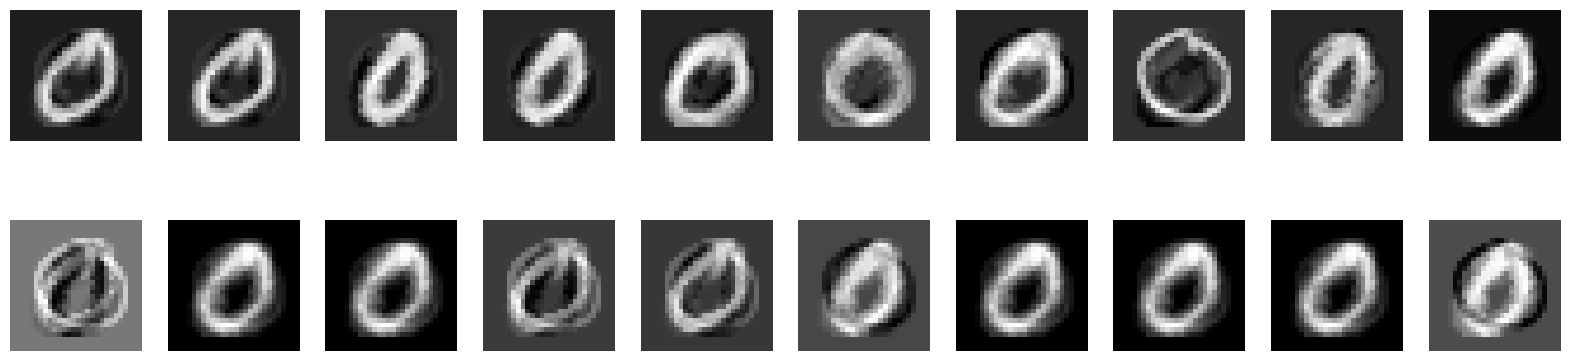

In [16]:
fig, (ax0, ax1) = plt.subplots(2,10,figsize=(20,5))
for idx, img_ in enumerate(data_decomp):
    ax0[idx].imshow(img_.reshape([28,28]), cmap = 'gray')
    ax0[idx].axis('off')

ws = output.get('gen_pca_img')
ws_ = []
for w in ws:
    w_ = pca_.inverse_transform(w)
    w_ = w_.reshape([28,28])*255
    ws_.append(w_)
n_plots = len(ws_)
for idx, im in enumerate(ws_):
    ax1[idx].imshow(im, cmap = 'gray')
    ax1[idx].axis('off')

# Plotting Outputs from different epochs

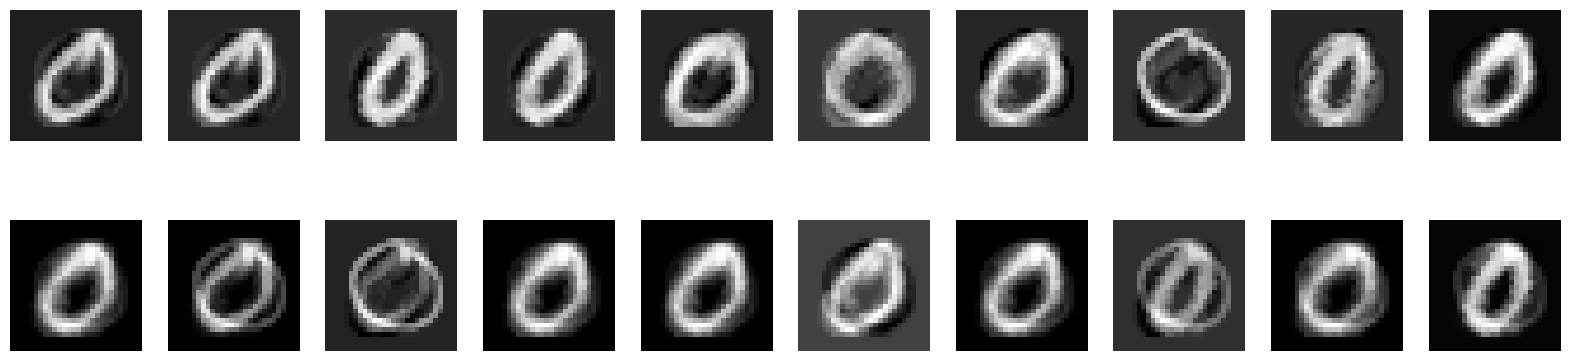

In [4]:
gen_h = output.get('w_gen_hist')

n_epoch = 4 #The epoch whose output we want to print
hs = gen_h[n_epoch]
hs_ = []
for h in hs:
    h_ = pca_.inverse_transform(h)
    h_ = h_.reshape([28,28])*255
    hs_.append(h_)

fig, (ax0, ax1) = plt.subplots(2,10,figsize=(20,5))
for idx, img_ in enumerate(data_decomp):
    ax0[idx].imshow(img_.reshape([28,28]), cmap = 'gray')
    ax0[idx].axis('off')



for idx, im in enumerate(hs_):
    ax1[idx].imshow(im, cmap = 'gray')
    ax1[idx].axis('off')


# Loss Functions Plots at different epochs

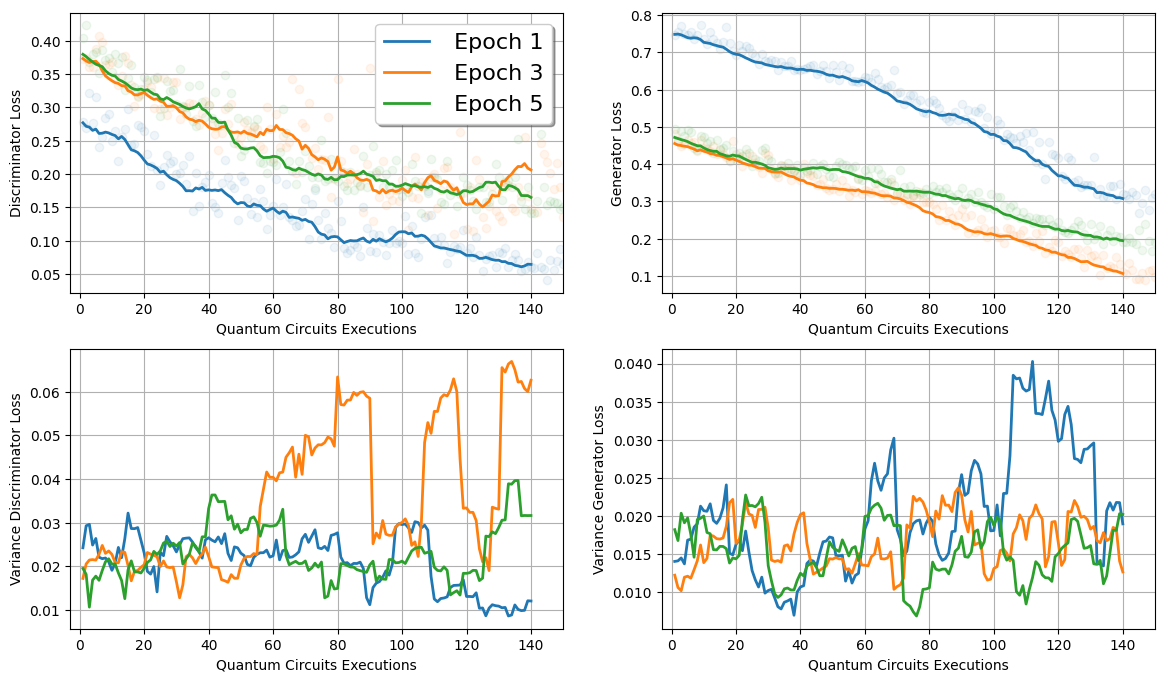

In [5]:
gen_data = output.get('gen_data')
x_gen_hist = output.get('x_gen_hist')
disc_training = output.get('disc_training')
gen_training = output.get('gen_training')

disc_train = np.array(disc_training)
gen_train = np.array(gen_training)

def mean_plot(data, window = 11):
    average_cost = []
    for ind in range(150 - window + 1):
        average_cost.append(np.mean(data[ind:ind+window]))
    return average_cost

def variance_plot(data, window = 11):
    variance_cost = []
    for ind in range(150 - window + 1):
        variance_cost.append(np.std(data[ind:ind+window]))
    return variance_cost


data =  [disc_train[0,i] for i in range(150)]
mean_data = mean_plot(data)    


fig, (ax1, ax2) = plt.subplots(2, 2, figsize= (14,8))
window = 11
xx = [i+1 for i in range(150)]
xx_ = [i+1 for i in range(150 - window + 1)]
for epoch in [0,2,4]:
    data =  [disc_train[epoch,i] for i in range(150)]
    data = np.array(data)
    mean_data = mean_plot(data)
    mean_data = np.array(mean_data)
    ax1[0].scatter(xx, data, marker = 'o', alpha = 0.07)
    ax1[0].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    mean_data = variance_plot(data)
    ax2[0].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    data =  [gen_train[epoch,i] for i in range(150)]
    mean_data = mean_plot(data)
    data = np.array(data)
    mean_data = np.array(mean_data)
    ax1[1].scatter(xx, data, marker = 'o', alpha = 0.07)
    ax1[1].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))
    mean_data = variance_plot(data)
    ax2[1].plot(xx_, mean_data, lw = 2, label = ' Epoch '+str(epoch+1))

axis_font = {'fontname':'Times New Roman', 'size':'20'}
ax1[0].set_xlabel(r'Quantum Circuits Executions' )
ax2[0].set_xlabel(r'Quantum Circuits Executions' )
ax1[1].set_xlabel(r'Quantum Circuits Executions' )
ax2[1].set_xlabel(r'Quantum Circuits Executions' )

ax1[0].set_ylabel(r'Discriminator Loss' )
ax1[1].set_ylabel(r'Generator Loss')
ax2[0].set_ylabel(r'Variance Discriminator Loss' )
ax2[1].set_ylabel(r'Variance Generator Loss')

ax1[0].set_xlim((-3,150))
ax2[0].set_xlim((-3,150))
ax1[1].set_xlim((-3,150))
ax2[1].set_xlim((-3,150))

ax1[0].legend(fontsize=16, shadow=True)
ax1[0].grid(True)
ax1[1].grid(True)
ax2[0].grid(True)
ax2[1].grid(True)